# Reproduce Figure 7

# Setup BART and inkscape (on Colab)

This notebook requires BART (v0.9.00) to perform data processing and reconstructions and inkscape to join the individual PNGs to the final figure.

If this notebook is run on Google Colab, the setup is performed in the following cells. If not, it is assumed that the tools are installed manually.

In [ ]:
# environment to check if on Colab

import os

if os.getenv("COLAB_RELEASE_TAG"):
  os.environ["COLAB"] = "1"
else:
  os.environ["COLAB"] = "0"

Install dependencies

%%bash

[ $COLAB -ne 1 ] && echo "Skipp cell (not on Colab)" && exit 0

# Install BARTs dependencies
apt-get install -y make gcc libfftw3-dev liblapacke-dev libpng-dev libopenblas-dev &> /dev/null

# Install inkscape
apt-get install -y inkscape &> /dev/null

Clone BART from github, checkout v0.9.00 and build it.

In [ ]:
%%bash

[ $COLAB -ne 1 ] && echo "Skipp cell (not on Colab)" && exit 0

# Clone Bart
[ -d bart ] && rm -r bart

git clone https://github.com/mrirecon/bart/ bart &> /dev/null

cd bart

git checkout v0.9.00

make &> /dev/null

In [ ]:
pip install fastmri

# Imports

In [1]:
## imports 
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import binary_dilation, binary_erosion, binary_closing
from fastmri.data import transforms, subsample
import torch
import cfl
import xml.etree.ElementTree as ET
from PIL import Image
import os
import sys

if 'BART_TOOLBOX_PATH' in os.environ and os.path.exists(os.environ['BART_TOOLBOX_PATH']):
	sys.path.append(os.path.join(os.environ['BART_TOOLBOX_PATH'], 'python'))
elif 'TOOLBOX_PATH' in os.environ and os.path.exists(os.environ['TOOLBOX_PATH']):
	sys.path.append(os.path.join(os.environ['TOOLBOX_PATH'], 'python'))
else:
	raise RuntimeError("BART_TOOLBOX_PATH is not set correctly!")

from bart import bart

# Utils

In [2]:
# Utils 
# Mask generation function
def create_brain_masks(mri_scan, loose_padding=5, hole_structre=5):
    normalized_scan = (mri_scan - mri_scan.min()) / (mri_scan.max() - mri_scan.min()) # Normalize 

    # thresholding
    tight_mask = normalized_scan > 0.1  
    # Fill holes in the tight mask using binary closing
    structure = np.ones((hole_structre, hole_structre))  
    structure_erosion = np.ones((10, 10)) 
    
    tight_mask = binary_closing(tight_mask, structure=structure)
    tight_mask = binary_erosion(tight_mask, structure=structure_erosion)

    # Create a wide mask by applying dilation to the tight mask
    loose_mask = binary_dilation(tight_mask, structure=structure, iterations=loose_padding)
    loose_mask = binary_erosion(loose_mask, structure=structure_erosion)

    return tight_mask.astype(np.uint8), loose_mask.astype(np.uint8)

def ifft2c(kspace):
    return np.fft.ifftshift(np.fft.ifft2(np.fft.fftshift(kspace, axes=(0, 1)), axes=(0, 1)), axes=(0, 1))

def fft2c(image):
    return np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(image, axes=(0, 1)), axes=(0, 1)), axes=(0, 1))

def calc_NRMSE(I_pred,I_true):    
        # Reshape the images into vectors
        I_true = np.reshape(I_true,(1,-1))   
        I_pred = np.reshape(I_pred,(1,-1))               
        # Mean Square Error
        MSE = np.square(np.subtract(I_true,I_pred)).mean()       
        # Root Mean Square Error
        RMSE = np.sqrt(MSE)
        # Normalized Root Mean Square Error
        rr = np.max(I_true) - np.min(I_true) # range
        NRMSE = RMSE/rr
        return NRMSE

def crop_image_vertical(data, crop_fraction=0.2):
    """
    Crops the upper and lower parts of the data.
    Args:
        data: 2D or 3D array to crop.
        crop_fraction: Fraction to crop from the top and bottom.
    Returns:
        Cropped data.
    """
    height = data.shape[0]
    crop_size = int(height * crop_fraction)
    return data[crop_size:height - crop_size, ...]

def crop_image_horizontal(data, crop_fraction=0.2):
    """
    Crops the upper and lower parts of the data.
    Args:
        data: 2D or 3D array to crop.
        crop_fraction: Fraction to crop from the top and bottom.
    Returns:
        Cropped data.
    """
    width = data.shape[1]
    crop_size = int(width * crop_fraction)
    return data[:,crop_size:width - crop_size, ...]

# Read raw data

In [ ]:
%%bash
# in case online
#bart twixread -A meas_MID00709_FID13299_t2_tse_tra_R=1.dat ksp_all
#bart slice 13 11 ksp_all ksp_fully
# For bart pyhton can use bart(1,'slice 13 11',ksp_all)

In [3]:
# local data
ksp_all = cfl.readcfl('ksp_fully.hdr')
print(ksp_all.shape)
slice_ksp_r1 = ksp_all 
print(slice_ksp_r1.shape)
slice_ksp_r1 = slice_ksp_r1[:,:,0,:]
print(slice_ksp_r1.shape)

(640, 420, 1, 32, 1, 1, 1, 1, 1, 1, 1, 1, 1, 38)
(640, 420, 1, 32)
(640, 420, 32)


# Generate sampling mask

In [4]:
def get_mask_func( factor):
    center_fractions = 0.06 * 4/factor # EquiSpacedMaskFunc
    mask_func = subsample.EquiSpacedMaskFunc(
    center_fractions=[center_fractions],
    accelerations=[factor], 
    )
    return mask_func
mask_func = get_mask_func(2)
mask = transforms.apply_mask(torch.ones(640,420,32), mask_func)[0]
undersampling_mask = mask.numpy()

# Data processing

In [5]:
# Cuts of background
slice_vertical = 0.26
slice_horizontal = 0.2

#Prewhiten
scan = bart(1,'fft -i -u 1',slice_ksp_r1 )
noise = bart(1,'transpose 1 0',scan)
ksp_white = bart(1,'whiten -n',slice_ksp_r1,noise)

slice_ksp_r1 = ksp_white  # the data is kspace
slice_r1 = ifft2c(slice_ksp_r1)


slice_rss_r1 = np.sqrt(np.sum(np.abs(slice_r1) ** 2, axis=-1)) # RSS of scan
slice_rss_r1 = np.flipud(slice_rss_r1[:,:]) # Flipup
slice_rss_r1_cropped = crop_image_vertical(slice_rss_r1, crop_fraction=slice_vertical)  # Crop the RSS 
slice_rss_r1_cropped = crop_image_horizontal(slice_rss_r1_cropped, crop_fraction=slice_horizontal)  # Crop the RSS 

# Generate accelerated data using the fully-sampled data
slice_ksp_r2 = slice_ksp_r1 * undersampling_mask  
slice_r2 = ifft2c(slice_ksp_r2)
slice_rss_r2 = np.sqrt(np.sum(np.abs(slice_r2) ** 2, axis=-1)) # RSS of scan
slice_rss_r2 = np.flipud(slice_rss_r2[:,:]) # Flipup
slice_rss_r2_cropped = crop_image_vertical(slice_rss_r2, crop_fraction=slice_vertical)  # Crop the RSS 
slice_rss_r2_cropped = crop_image_horizontal(slice_rss_r2_cropped, crop_fraction=slice_horizontal)  # Crop the RSS 

r2_image = slice_rss_r2_cropped
r1_image = slice_rss_r1_cropped

# Metric scores calculation masks generation

In [6]:
#Masks generation 
tight_mask, wide_mask = create_brain_masks(r1_image, loose_padding=1,hole_structre=40)
no_mask = np.ones(r1_image.shape) # Only frame
no_mask[:,-3:-1] = 0
no_mask[:,0:3] = 0
no_mask[0:3,:] = 0
no_mask[-3:-1,:] = 0


# Calculate NRMSE scores

In [7]:
# NRMSE calculation
no_mask_nrmse = calc_NRMSE(r2_image,r1_image)
wide_mask_nrmse = calc_NRMSE(r2_image*wide_mask,r1_image*wide_mask)
tight_mask_nrmse = calc_NRMSE(r2_image*tight_mask,r1_image*tight_mask)

print(f'NRMSE with no mask: {no_mask_nrmse:.3f}')
print(f'NRMSE with loose mask: {wide_mask_nrmse:.3f}')
print(f'NRMSE with tight mask: {tight_mask_nrmse:.3f}')

NRMSE with no mask: 0.026
NRMSE with loose mask: 0.024
NRMSE with tight mask: 0.021


# Plot

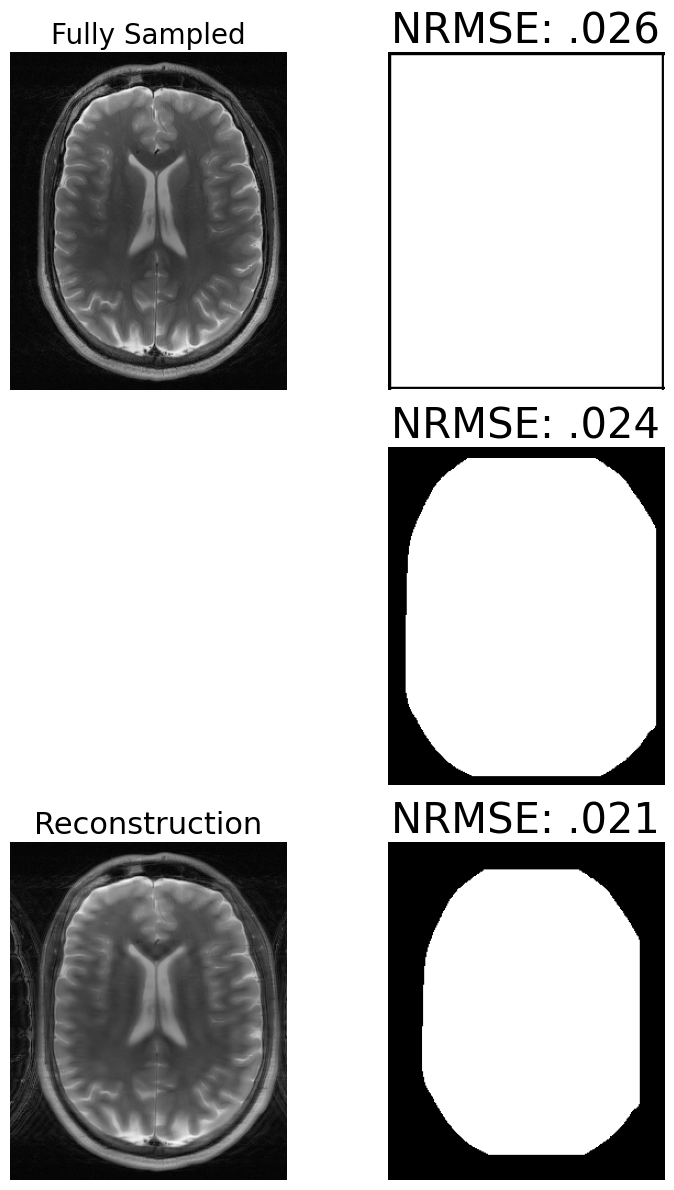

In [8]:
# Plot
plt.figure(figsize=(8, 12))

# Fully Sampled
plt.subplot(3, 2, 1)
plt.title("Fully Sampled", fontsize=20)
plt.imshow(np.sqrt(r1_image), cmap='gray')
plt.axis('off')  # Remove all axes
# Reconstruction
plt.subplot(3, 2, 5)
plt.title("Reconstruction", fontsize=22)
plt.imshow(np.sqrt(r2_image), cmap='gray')
plt.axis('off')  

## Masks
# Tight mask
plt.subplot(3, 2, 6)
tight_mask_label = f"NRMSE: {tight_mask_nrmse:.3f}".replace("0.", ".")
plt.title(tight_mask_label, fontsize=30)
plt.imshow(np.sqrt(tight_mask), cmap='gray')
plt.axis('off')
# wide mask
plt.subplot(3, 2, 4)
wide_mask_label = f"NRMSE: {wide_mask_nrmse:.3f}".replace("0.", ".")
plt.title(wide_mask_label, fontsize=30)
plt.imshow(np.sqrt(wide_mask), cmap='gray')
plt.axis('off')
# No Mask
plt.subplot(3, 2, 2)
no_mask_label = f"NRMSE: {no_mask_nrmse:.3f}".replace("0.", ".")
plt.title(no_mask_label, fontsize=30)
plt.imshow(np.sqrt(no_mask), cmap='gray')
plt.axis('off')

# Adjust layout
plt.tight_layout()
# Show the plot
plt.show()

# Combine results with inkscape template for final figure

In [9]:

## For Saving plot as the paper

# Create plots of Fully-Sampled & Reconstruction
plt.figure(figsize=(5, 8))
plt.imshow(np.sqrt(r2_image), cmap='gray')
plt.axis('off')
# Save as PNG
plt.savefig("plot_2.png", dpi=900, bbox_inches='tight', pad_inches=0)
plt.close()

plt.figure(figsize=(5, 5))
plt.imshow(np.sqrt(r1_image), cmap='gray')
plt.axis('off')
plt.savefig("plot_1.png", dpi=900, bbox_inches='tight', pad_inches=0)
plt.close()

# Masks plots
plt.figure(figsize=(5, 5))
no_mask_label = f"NRMSE: {no_mask_nrmse:.3f}".replace("0.", ".")
plt.title(no_mask_label, fontsize=32)
plt.imshow(np.sqrt(no_mask), cmap='gray')
plt.axis('off')
plt.savefig("plot_3.png", dpi=900, bbox_inches='tight', pad_inches=0)
plt.close()

plt.figure(figsize=(5, 5))
wide_mask_label = f"NRMSE: {wide_mask_nrmse:.3f}".replace("0.", ".")
plt.title(wide_mask_label, fontsize=32)
plt.imshow(np.sqrt(wide_mask), cmap='gray')
plt.axis('off')
plt.savefig("plot_4.png", dpi=900, bbox_inches='tight', pad_inches=0)
plt.close()

plt.figure(figsize=(5, 5))
tight_mask_label = f"NRMSE: {tight_mask_nrmse:.3f}".replace("0.", ".")
plt.title(tight_mask_label, fontsize=32)
plt.imshow(np.sqrt(tight_mask), cmap='gray')
plt.axis('off')
plt.savefig("plot_5.png", dpi=900, bbox_inches='tight', pad_inches=0)
plt.close()

# Paths
svg_file = "./Fig_7_Masks_Template.svg"
output_file = "./updated_template.svg"

# List of PNG files and corresponding placeholders
images = [f"plot_{i}.png" for i in range(1, 6)]  # List of image file paths
placeholders = ['image1185-0-6-4','image1185-0-6','image1149-2', 'image1149-2-5','image1149-2-51' ]  # List of placeholder IDs in SVG

# Parse the SVG file
tree = ET.parse(svg_file)
root = tree.getroot()

# Define the SVG namespace
namespace = {'svg': 'http://www.w3.org/2000/svg'}
ET.register_namespace('', namespace['svg'])

# Loop through placeholders and images
for png_file, placeholder_id in zip(images, placeholders):
    # Find the placeholder rectangle by ID
    placeholder = root.find(f".//*[@id='{placeholder_id}']", namespace)

    if placeholder is not None:
        # Get placeholder dimensions
        placeholder_width = float(placeholder.attrib.get('width', '500'))
        placeholder_height = float(placeholder.attrib.get('height', '500'))
        placeholder_aspect = placeholder_width / placeholder_height

        # Calculate the PNG image's aspect ratio
        with Image.open(png_file) as img:
            png_width, png_height = img.size
        png_aspect = png_width / png_height

        # Adjust dimensions to preserve aspect ratio
        if png_aspect > placeholder_aspect:
            adjusted_width = placeholder_width
            adjusted_height = placeholder_width / png_aspect
        else:
            adjusted_height = placeholder_height
            adjusted_width = placeholder_height * png_aspect

        if placeholder_id in ['image1185-0-6-4','image1185-0-6']:
            x_offset = 10  # shift images
            y_offset = 0
        else:
            x_offset = -10  
            y_offset = -1
        

        # Create an <image> element
        image = ET.Element('image', {
            'x': str(float(placeholder.attrib.get('x', '0')) + x_offset), 
            'y': str(float(placeholder.attrib.get('y', '0')) + y_offset),  
            'width': f'{adjusted_width}',  
            'height': f'{adjusted_height}',  
            '{http://www.w3.org/1999/xlink}href': png_file  # Link to the PNG file
        })

        parent = root.find(f".//*[@id='{placeholder_id}']/..", namespace)
        parent.remove(placeholder)
        parent.append(image)

# Save the updated SVG file
tree.write(output_file)


%%bash

inkscape --export-filename=Figure_7_NRMSE_vs_mask.png updated_template.svg
